# Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To handle data wrangling
from sklearn.preprocessing import FunctionTransformer 
from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline

# To import best model
import pickle

# Load Data

In [2]:
# "Stores" data
stores = pd.read_csv('stores_data.csv', index_col='Store')

#### Training Data

In [3]:
dtypes = {'Store': int,
          'DayOfWeek':int,
          'Date':str,
          'Sales':int,
          'Customers':int,
          'Open':int,
          'Promo':int,
          'StateHoliday':str,
          'SchoolHoliday':int,
}

In [4]:
# Loading raw data
raw_data = pd.read_csv('train.csv', dtype=dtypes, index_col='Date', parse_dates = True)

# Dropping unnecessary rows/cols
train_data = raw_data[(raw_data.Sales > 0) & (raw_data.Open > 0)]
train_data = train_data.drop(['Open', 'Customers'], axis=1)

# Joining "stores" data
train_data = train_data.join(stores, on = 'Store')

#### Test Data

In [5]:
# Read test data
raw_test_data = pd.read_csv('test.csv', index_col = 'Date', parse_dates = True)

# Joining "stores" data
test_data = raw_test_data.join(stores, on = 'Store')

In [6]:
id_closed = test_data[test_data.Open == 0].Id
print('id_closed', id_closed.shape)

id_open = test_data[test_data.Open == 1].Id
print('id_open', id_open.shape)

id_null = test_data[(test_data.Open != 1) & (test_data.Open != 0)].Id
print('id_null', id_null.shape)

id_closed (5984,)
id_open (35093,)
id_null (11,)


In [7]:
# Dropping unnecessary rows/cols
test_data = test_data[(test_data.Open > 0)]
test_data = test_data.drop(['Open', 'Id'], axis=1)

### Splitting features & target

In [8]:
X_train = train_data.drop(['Sales'], axis = 1)
y_train = train_data.Sales

In [9]:
X_test = test_data

In [10]:
print(X_train.shape)
X_train.head(3)

(844338, 21)


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Promo2SinceYear,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,1,0,1,148,7.146772,9,2008,0,...,0,1,0,0,1,0,0,0,37509,287
2015-07-31,2,5,1,0,1,602,6.345636,11,2007,1,...,2010,1,0,0,0,1,0,0,21663,138
2015-07-31,3,5,1,0,1,602,9.556055,12,2006,1,...,2011,1,0,0,0,1,0,0,32882,523


In [11]:
print(X_test.shape)
X_test.tail(3)

(35093, 21)


,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Promo2SinceYear,Assortment_basic,Assortment_extended,Assortment_extra,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-01,1113,6,0,0,0,602,9.133459,8,2010,0,...,0,0,1,0,1,0,0,0,25947,179
2015-08-01,1114,6,0,0,0,602,6.768493,8,2010,0,...,0,0,1,0,1,0,0,0,52401,2368
2015-08-01,1115,6,0,0,1,348,8.584852,8,2010,1,...,2012,0,1,0,0,0,0,1,37509,287


# Configuration

## Target

In [12]:
y_train = np.log(y_train)

## Features

In [13]:
def extract_dates(df):
    df = df.copy()
    
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Day'] = df.index.day
    
    return df

In [14]:
HOLIDAY_MAPPING = {'0':0, 'a':1, 'b':1, 'c':1}

def map_holidays(df):
    df = df.copy()
    df.StateHoliday = df.StateHoliday.replace(HOLIDAY_MAPPING)
    
    return df

In [15]:
with open("dict_day_cust.pkl", "rb") as fp:   
    dict_day_cust = pickle.load(fp)     
    
def daily_customers(df):
    df['AvgWeaklyCusts'] = df.Week.replace(dict_day_cust)
    
    return df

# Pipeline

In [16]:
pipe = Pipeline([
#   ==== ADDING DATE FEATURES ==== 
     ('date_features', FunctionTransformer(extract_dates)),

#   ==== MAPPING ==== 
     ('holidays', FunctionTransformer(map_holidays)),    
    
    
#   ==== ADDING DAILY CUSTOMERS ==== 
     ('daily_customers', FunctionTransformer(daily_customers)),    
        

#    ==== DROP FEATURES ====
    # Unnecessary feature
    ('drop_stores', DropFeatures(features_to_drop = ['Store'])),
        
])

In [17]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('date_features',
                 FunctionTransformer(func=<function extract_dates at 0x000001E3395413A0>)),
                ('holidays',
                 FunctionTransformer(func=<function map_holidays at 0x000001E339541310>)),
                ('daily_customers',
                 FunctionTransformer(func=<function daily_customers at 0x000001E339541940>)),
                ('drop_stores', DropFeatures(features_to_drop=['Store']))])

In [18]:
## Transform datasets & get feature names
X_train = pipe.transform(X_train)
feat_names = X_train.columns

In [19]:
X_test = pipe.transform(X_test)

# Model

In [20]:
%%time
with open("RFRegressor.pkl", "rb") as fp:  
    model = pickle.load(fp)

model.fit(X_train, y_train)

Wall time: 45.4 s


RandomForestRegressor(max_depth=48, max_features=24, max_samples=0.8,
                      min_samples_leaf=2, min_samples_split=3, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [21]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
y_pred

array([ 4136.15980729,  7611.89405383,  9015.89700287, ...,
        6449.4624308 , 20825.63704512,  7515.36936757])

In [22]:
# Scale back predictions as suggested in https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17601
y_pred_scaled = y_pred * 0.985

In [23]:
dic_open = {key:value for (key, value) in zip(id_open, y_pred_scaled)}
dic_closed = {key:0 for key in id_closed}
dic_null = {key:np.exp(y_train.mean()) for key in id_null} #average price in train set

In [24]:
def merge_dicts(*dict_args):
    """
    Given any number of dictionaries, shallow copy and merge into a new dict,
    precedence goes to key-value pairs in latter dictionaries.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

In [26]:
predictions = merge_dicts(dic_open, dic_closed, dic_null)

In [27]:
df_pred = pd.DataFrame(predictions.items(), columns = ['Id', 'Sales'])
df_pred = df_pred.sort_values('Id')

In [28]:
df_pred.index = df_pred.loc[:, 'Id']
df_pred.drop(['Id'], axis = 1).head()

,Sales
Id,
1,4074.117410
2,7497.715643
3,8880.658548
4,7054.068734
5,7169.259282


In [29]:
df_pred.to_csv('submission_scaled.csv', index = False)

# Forecasting plot

In [30]:
y_true_july = raw_data.loc['2015'][['Sales']]

df_sales_pred = pd.DataFrame(predictions.values(), 
                        index = raw_test_data.index, 
                        columns = ['Forecasting'])

In [31]:
sales_forecasting = pd.concat([df_sales_pred, y_true_july])

In [32]:
# Set custom palette
colors = ['#E85D04', '#B71D3E']
sns.set_palette(sns.color_palette(colors))

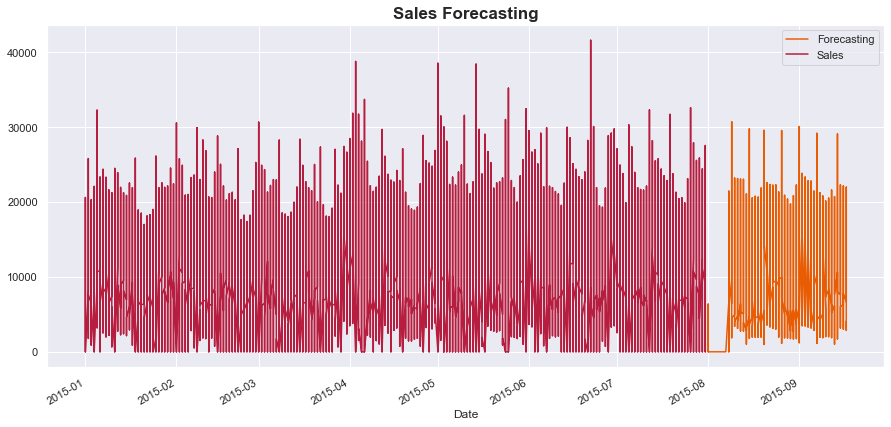

In [33]:
sales_forecasting.plot(figsize = (15, 7))
plt.legend()
plt.title('Sales Forecasting', weight = 'bold', size = 17)
plt.show()

In [34]:
sales_forecasting.to_csv('sales_forecasting.csv')